In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/pt/r0f84gpd53ndj2ptsk854sfw0000gn/T/ipykernel_60024/430117948.py:6: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())


['station', 'measurement']


In [7]:
# Save references to each table

Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

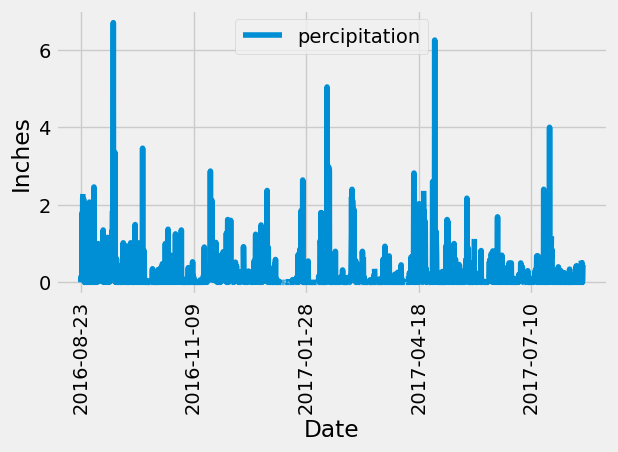

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()


# Calculate the date one year from the last date in data set.
one_year_ago = func.date(most_recent_date, '-1 year')


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_precipitation = pd.DataFrame(precipitation_data, columns=['date', 'percipitation'])
df_precipitation.set_index('date', inplace=True)


# Sort the dataframe by date
df_precipitation.sort_index(inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
df_precipitation.plot()
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = df_precipitation['percipitation'].describe()

summary_df = pd.DataFrame(summary)

summary_df

,percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(Station.station)).scalar()

total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station)
).group_by(
    Measurement.station
).order_by(
    func.count(Measurement.station).desc()
).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = 'USC00519281'

temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(
    Measurement.station == most_active_station_id
).all()

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

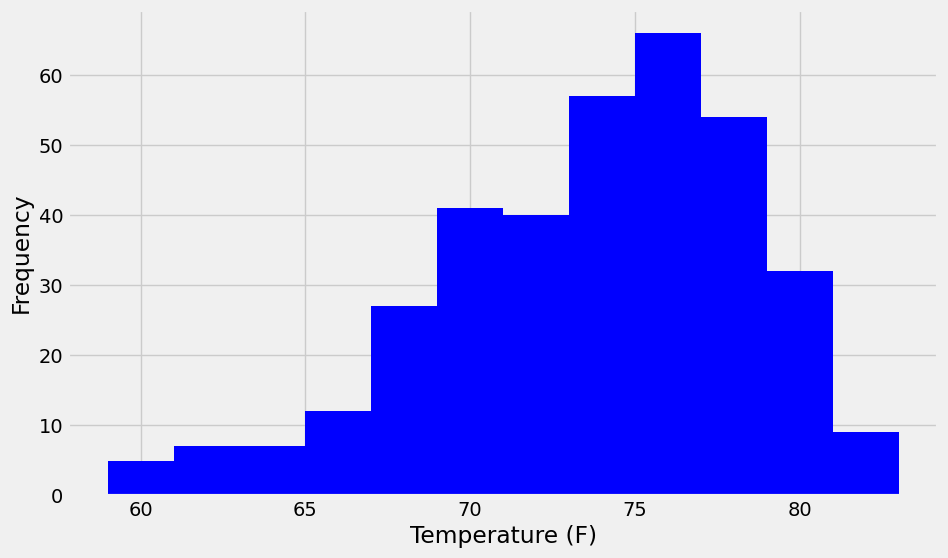

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_recent_date, one_year_ago = session.query(
    Measurement.date,
    func.date(func.max(Measurement.date), '-1 year')
).filter(
    Measurement.station == most_active_station_id
).first()

temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

temperatures = [temp[0] for temp in temperature_data]

plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, color='blue')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Close Session

In [16]:
# Close Session
session.close()